##### Master Degree in Computer Science and Data Science for Economics

# Sequence 2 sequence generation with attention

### Alfio Ferrara

See also the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

### Preparazione dei dati

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#!pwd
!pip install roman-arabic-numerals
from roman_arabic_numerals import conv

import os

%cd /content/
!ls -R
repo_name = "NLP_COURSE"
#!rm -rf {repo_name}
if not os.path.exists(repo_name):
    print(f"Directory {repo_name} does not exist, proceeding with clone.")
    !git clone https://github.com/Abudo-S/NLP_COURSE.git

%cd NLP_COURSE

/content
.:
sample_data

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md
Directory NLP_COURSE does not exist, proceeding with clone.
Cloning into 'NLP_COURSE'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 181 (delta 37), reused 10 (delta 2), pack-reused 106 (from 1)
Receiving objects: 100% (181/181), 66.82 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Filtering content: 100% (14/14), 800.44 MiB | 57.05 MiB/s, done.
/content/NLP_COURSE


In [ ]:
folder = '/content/NLP_COURSE'
classification_path = '{}/data/roman_number-classification.csv'.format(folder)
data = pd.read_csv(classification_path)
data.head(2)

,sequence,target
0,___CXXXIII,odd
1,____CXCVII,odd


In [ ]:
numbers = [x.replace('_', '') for x in data.sequence.values]
arabic = [str(conv.rom_arab(n)) for n in numbers]
numbers[:3], arabic[:3]

(['CXXXIII', 'CXCVII', 'XCIX'], ['133', '197', '99'])

#### Input and output
**Encoder**: vec(XII) $\rightarrow$ context_vector

**Decoder**:
$$
\textrm{context\_vector} \rightarrow \begin{matrix}
\langle SOS \rangle & \rightarrow & 1 \\
\langle 1 \rangle & \rightarrow & 2 \\
\langle 2 \rangle & \rightarrow & \langle EOS \rangle \\
\end{matrix}
$$

In [ ]:
%cd nlp/nlp
import utils

[Errno 2] No such file or directory: 'nlp/nlp'
/content/NLP_COURSE/nlp/nlp


In [ ]:
roman_vocabulary, arabic_vocabulary = utils.Lang(name='roman'), utils.Lang('arabic')

In [ ]:
for i, r in enumerate(numbers):
    a = arabic[i]
    roman_vocabulary.add_word(r)
    arabic_vocabulary.add_word(a)

## Training

### Data preparation

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch
import neurnets as net

In [ ]:
input_vocabulary = roman_vocabulary
target_vocabulary = arabic_vocabulary

def indexes_from_word(lang, word):
    return [lang.letter2index[c] for c in word]

def word_tensor(lang, word):
    indexes = indexes_from_word(lang, word)
    indexes.append(utils.EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(1, -1)

def pari_tensors(pair):
    input_tensor = word_tensor(input_vocabulary, pair[0])
    target_tensor = word_tensor(target_vocabulary, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = input_vocabulary, target_vocabulary, [(n, arabic[i]) for i, n in enumerate(numbers)]

    n = len(pairs)
    input_ids = np.zeros((n, net.MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, net.MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexes_from_word(input_lang, inp)
        tgt_ids = indexes_from_word(output_lang, tgt)
        inp_ids.append(utils.EOS_token)
        tgt_ids.append(utils.EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(target_ids))
    #RandomSampler ensures that the data is shuffled at each epoch, which is important for training machine learning models
    #to prevent the model from learning the order of the data.
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
batch_size = 4
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=batch_size)

In [ ]:
for x in train_dataloader:
    print(x)

[tensor([[6, 4, 3, 1, 0, 0, 0, 0, 0, 0],
        [3, 6, 5, 4, 4, 4, 1, 0, 0, 0],
        [6, 3, 4, 1, 0, 0, 0, 0, 0, 0],
        [3, 3, 5, 1, 0, 0, 0, 0, 0, 0]]), tensor([[ 6,  4,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 9,  8,  1,  0,  0,  0,  0,  0,  0,  0],
        [11,  2,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 7,  6,  1,  0,  0,  0,  0,  0,  0,  0]])]
[tensor([[3, 4, 5, 1, 0, 0, 0, 0, 0, 0],
        [2, 2, 4, 4, 4, 1, 0, 0, 0, 0],
        [6, 4, 4, 1, 0, 0, 0, 0, 0, 0],
        [6, 3, 4, 1, 0, 0, 0, 0, 0, 0]]), tensor([[ 2,  9,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 7, 10,  3,  1,  0,  0,  0,  0,  0,  0],
        [ 6,  7,  1,  0,  0,  0,  0,  0,  0,  0],
        [11,  2,  1,  0,  0,  0,  0,  0,  0,  0]])]
[tensor([[6, 3, 3, 4, 5, 1, 0, 0, 0, 0],
        [2, 6, 5, 4, 4, 4, 1, 0, 0, 0],
        [2, 3, 6, 5, 4, 4, 1, 0, 0, 0],
        [2, 2, 3, 6, 4, 4, 4, 1, 0, 0]]), tensor([[5, 9, 1, 0, 0, 0, 0, 0, 0, 0],
        [2, 6, 8, 1, 0, 0, 0, 0, 0, 0],
        [2, 9, 5, 1, 0, 0, 

### Training functions

In [ ]:
from tqdm.notebook import tqdm
from torch import nn

### RNN deconder attention
The attention mechanism enhances the decoder by giving it access to all of the encoder's hidden states, not just the final one. At each decoding step, it dynamically creates a new, refined context vector.

Process steps:
* Encoder States: The encoder processes the input sequence and produces a series of hidden states. Each hidden state, hi​, contains information about that specific word and its context in the input sentence.
* Scoring and Alignment: At each time step of the decoder, a score is calculated for every single encoder hidden state. This score measures how "relevant" each input word's hidden state is to the decoder's current task (i.e., generating the next output word). This scoring is done using a function that takes the current decoder hidden state and each of the encoder hidden states.
* Attention Weights: The scores are then passed through a softmax function to get a set of attention weights, αij​. These weights are probabilities that sum to 1, indicating the relative importance of each input word. A higher weight means the decoder should "pay more attention" to that corresponding input word at this specific decoding step.
* Context Vector Creation: The attention weights are used to compute a weighted sum of the encoder's hidden states. The result of this sum is a new, dynamic context vector, ct​. This vector is tailored specifically for the current decoder time step, highlighting the most relevant information from the input.
* Output Generation: The decoder then uses its previous hidden state, the previous output word, and the newly created context vector, ct​, to predict the next word in the output sequence.  

Solves the Bottleneck Problem: Attention avoids the need to compress all information into a single vector, allowing the model to handle long sequences effectively.

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
        decoder_optimizer, criterion):

    total_loss = 0
    for input_tensor, target_tensor in dataloader:
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        #view() reshape a tensor without changing its underlying data.
        #It returns a new compatible tensor with the same data as the original tensor but with a different shape.
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs,
        learning_rate=0.001, plot_every=100):
    history = []
    plot_loss_total = 0  # Reset every plot_every
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    run = list(range(n_epochs))
    for epoch in tqdm(run):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        plot_loss_total += loss

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            history.append(plot_loss_avg)
            plot_loss_total = 0

    return history

## Training

In [ ]:
hidden_size = 16
batch_size = 4
epochs = 200

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

#uses nn.GRU(hidden_size, hidden_size, batch_first=True)
#batch_first=True: This indicates that the input and output tensors will have the batch size as the first dimension.
encoder = net.EncoderRNN(input_lang.n_letters, hidden_size)

#uses BahdanauAttention and nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
decoder = net.DecoderRNN(hidden_size, output_lang.n_letters)

history = train(train_dataloader, encoder, decoder, epochs, plot_every=5)

  0%|          | 0/200 [00:00<?, ?it/s]

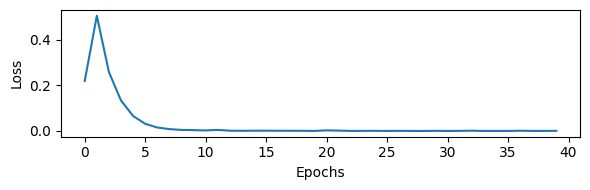

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.tight_layout()
plt.show()

## Evaluation

In [ ]:
def evaluate(encoder, decoder, word, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = word_tensor(input_lang, word=word)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_letters = []
        for idx in decoded_ids:
            if idx.item() == utils.EOS_token:
                decoded_letters.append('<EOS>')
                break
            decoded_letters.append(output_lang.index2letter[idx.item()])
    return decoded_letters, decoder_attn

nn.Module.eval() is a method in PyTorch that sets a module (like a neural network layer or the entire model) to evaluation mode.  

Dropout and Batch Normalization: Layers like Dropout and Batch Normalization behave differently during training and evaluation.

* Dropout: During training, dropout randomly sets a fraction of input units to zero to prevent overfitting. During evaluation, dropout is turned off, and the weights are scaled accordingly.
* Batch Normalization: During training, batch normalization uses the mean and variance of the current mini-batch to normalize the inputs. During evaluation, it uses the learned running mean and variance accumulated during training.

By calling model.eval(), we ensure that these layers are set to their appropriate evaluation behavior. This is crucial for getting consistent and accurate results when evaluating our model on a test set or making predictions.

It's important to remember to switch back to training mode using model.train() when we resume training.


In [ ]:
encoder.eval()
decoder.eval()
test = 'XXIII'
out, attn = evaluate(encoder, decoder, test, roman_vocabulary, arabic_vocabulary)
print(out)

['3', '3', '<EOS>']


In [ ]:
attention = attn[0].detach().numpy()
attention.shape

(10, 6)

In [ ]:
attention

array([[2.4368662e-02, 9.5497638e-01, 5.1667867e-03, 5.5328645e-03,
        5.6723487e-03, 4.2829979e-03],
       [2.2010364e-02, 1.9853967e-03, 1.2966393e-02, 3.5363272e-01,
        5.0659710e-01, 1.0280801e-01],
       [6.7123123e-02, 1.8974163e-02, 4.2415536e-03, 1.5731864e-02,
        6.2579624e-02, 8.3134973e-01],
       [2.9907635e-01, 1.9342361e-01, 3.3763207e-02, 1.7510714e-02,
        5.7251610e-02, 3.9897451e-01],
       [1.6289679e-02, 2.7886193e-04, 4.2731877e-02, 2.6975560e-01,
        3.4710345e-01, 3.2384050e-01],
       [1.2717732e-02, 1.8887647e-04, 3.2942206e-02, 2.5386569e-01,
        3.6184707e-01, 3.3843851e-01],
       [1.2429291e-02, 1.8940956e-04, 3.2115161e-02, 2.5042588e-01,
        3.6293846e-01, 3.4190187e-01],
       [1.2447822e-02, 1.9199455e-04, 3.1811770e-02, 2.4904349e-01,
        3.6366701e-01, 3.4283787e-01],
       [1.2559920e-02, 1.9454279e-04, 3.1629231e-02, 2.4833107e-01,
        3.6432955e-01, 3.4295565e-01],
       [1.2714103e-02, 1.9700750e-04,